# 目前官方的 lambert投影不支持添加经纬度

In [1]:
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,cartopy_xlim, cartopy_ylim)
from wrf import  smooth2d, get_basemap, latlon_coords
import numpy as np
import xarray
import arrow
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from mpl_toolkits.basemap import Basemap

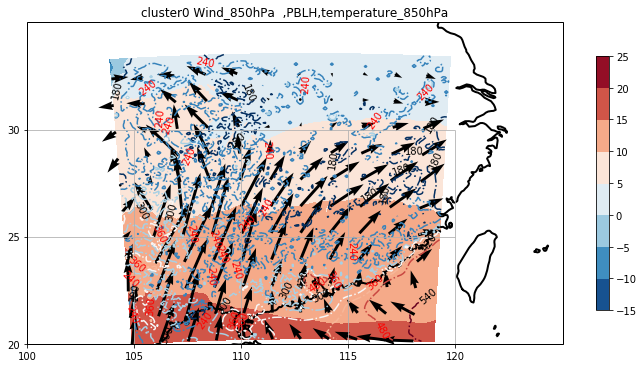

In [8]:
##0
ds_mean = xarray.open_dataset('cluster_0_mean.nc')
ncfile_mean=nc.Dataset('cluster_0_mean.nc')
ds = xarray.open_dataset(flnm_cluster0) #just get the pro inoformation
ncfile=nc.Dataset(flnm_cluster0)
lats, lons = latlon_coords(ds_mean['SW'])
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from copy import copy
import numpy as np
import shapely.geometry as sgeom
import cartopy.crs as ccrs
def find_side(ls, side):
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],

              'right': [(maxx, miny), (maxx, maxy)],

              'bottom': [(minx, miny), (maxx, miny)],

              'top': [(minx, maxy), (maxx, maxy)],}

    return sgeom.LineString(points[side])
def lambert_xticks(ax, ticks):

    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""

    te = lambda xy: xy[0]

    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T

    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)

    ax.xaxis.tick_bottom()

    ax.set_xticks(xticks)

    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
def lambert_yticks(ax, ticks):

    """Draw ticks on the left y-axis of a Lamber Conformal projection."""

    te = lambda xy: xy[1]

    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T

    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)

    ax.yaxis.tick_left()

    ax.set_yticks(yticks)

    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])
def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):

    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""

    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())

    axis = find_side(outline_patch, tick_location)

    n_steps = 30

    extent = ax.get_extent(ccrs.PlateCarree())

    _ticks = []

    for t in ticks:

        xy = line_constructor(t, n_steps, extent)

        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])

        xyt = proj_xyz[..., :2]

        ls = sgeom.LineString(xyt.tolist())

        locs = axis.intersection(ls)

        if not locs:

            tick = [None]

        else:

            tick = tick_extractor(locs.xy)

        _ticks.append(tick[0])

    # Remove ticks that aren't visible:    

    ticklabels = copy(ticks)

    while True:

        try:

            index = _ticks.index(None)

        except ValueError:

            break

        _ticks.pop(index)

        ticklabels.pop(index)

    return _ticks, ticklabels
#plt.rcParams['savefig.dpi'] = 300 #图片像素
#plt.rcParams['figure.dpi'] = 300 #分辨
ds = xarray.open_dataset(flnm_cluster0)
ncfile=nc.Dataset(flnm_cluster0)
p = getvar(ncfile, "pressure")
z = getvar(ncfile, "z", units="dm")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
tc = getvar(ncfile, "tc")
wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]
ht_500 = interplevel(z, p, 800)
cart_proj = ccrs.LambertConformal(central_longitude=110, central_latitude=26,standard_parallels=(30, 60))
# Create the figure
fig = plt.figure(figsize=(12,9))
ax =  plt.axes(projection=ccrs.PlateCarree())#plt.axes(projection=crs.PlateCarree())  cart_proj
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",facecolor="none",name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=0.99, edgecolor="black")
ax.coastlines('50m', linewidth=2)
ax.set_xlim(cartopy_xlim(ht_500 ))
ax.set_ylim(cartopy_ylim(ht_500 ))
ax.set_extent([100,125,20,35],crs=ccrs.PlateCarree())
ax.set_xticks([100,120], crs=ccrs.PlateCarree())
ax.set_yticks([20,25,30], crs=ccrs.PlateCarree())
fig.canvas.draw()
xticks = list(range(100,125,5))
yticks = list(range(20,35,5))
ax.gridlines(xlocs=xticks, ylocs=yticks)
# 画温度用contourf
cm = ax.contourf(to_np(lons),to_np(lats), to_np(ds_mean['TA_850hPa']),levels=[-15,-10,-5,0,5,10,15,20,25],
                transform=ccrs.PlateCarree(),
               cmap='RdBu_r') #'nipy_spectral',,add_colorbar=True

cb = plt.colorbar(cm, orientation="vertical",cmap='RdBu_r',shrink=.52)
#画压强用contour
cr = ax.contour(to_np(lons),to_np(lats), to_np(ds_mean['PBLH']),
                transform=ccrs.PlateCarree(),linestyles= 'dashdot' ,
                cmap='RdBu_r') 
plt.clabel(cr,fontsize=10,fmt='%1.0f',colors=('k','r'))  #plt.clabel(S1,inline=1,inline_spacing=0,fontsize=8,fmt='%1.0f',colors='b')
uv_plot = plt.quiver(to_np(lons[::15,::15]), to_np(lats[::15,::15]), 
                     to_np(ds_mean['UU_850hPa'][::15,::15]),
                     to_np(ds_mean['VV_850hPa'][::15,::15])
                     ,transform=ccrs.PlateCarree())
# Set the map bounds
#ax.gridlines()
lambert_xticks(ax, xticks)  
lambert_yticks(ax, yticks)


plt.title("cluster0 Wind_850hPa  ,PBLH,temperature_850hPa")
plt.show()
fig.savefig('cls0')